## Importing Qiskit

In [1]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.finance import QiskitFinanceError
from qiskit.finance.data_providers import WikipediaDataProvider
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

C:\Users\Ahmed Dawoud\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\finance\__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')


## Pull Stock data

In [2]:
# set number of assets (= number of qubits)
stocks = ["GOOG", "AAPL", "NFLX", "ADBE", "IBM"]
num_assets = len(stocks)

# api key from Quandl!
token = "HRXZqqxBka_9huabBgoW"

try:
    wiki = WikipediaDataProvider(
                        token = token,
                        tickers = stocks,
                        start = datetime.datetime(2018,1,1),
                        end = datetime.datetime(2018,12,1))
    wiki.run()
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")

## Draw stock data

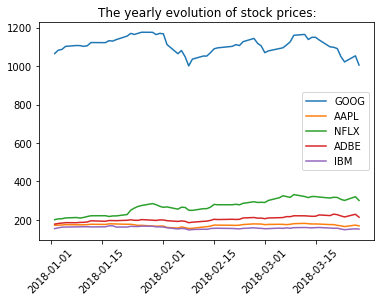

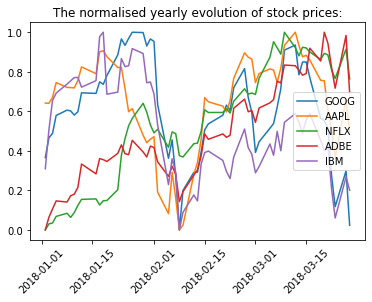

In [3]:
fig, axes = plt.subplots()
for (cnt, s) in enumerate(stocks):
    axes.plot(wiki._data[cnt], label=s)
plt.title("The yearly evolution of stock prices:")
plt.legend(loc="right")
plt.xticks(rotation=45)
plt.show()

fig, axes = plt.subplots()
for (cnt, s) in enumerate(stocks):
    min_ = np.min(wiki._data[cnt])
    max_ = np.max(wiki._data[cnt])
    norm = (wiki._data[cnt] - min_)/(max_- min_)
    axes.plot(norm, label=s)
plt.legend(loc="right")
plt.title("The normalised yearly evolution of stock prices:")
plt.xticks(rotation=45)
plt.show()

In [4]:
mu = wiki.get_period_return_mean_vector()
sigma = wiki.get_period_return_covariance_matrix()

## Set our Optimization Parameters

In [5]:
# set risk factor
q = 0.5
# set budget
budget = 2
# set parameter to scale the budget penalty term
penalty = num_assets

# Create a Qubit operator
qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

# Prep for solvers
seed = 50

# Set up the classical optimiser
cobyla = COBYLA()
cobyla.set_options(maxiter=500)

# Set up the quantum instance backend
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

## Classical Solver

In [6]:
# Classical Solver
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
np_result = exact_eigensolver.run()

In [7]:
# QAOA Solver
qaoa_counts = []
qaoa_values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    qaoa_counts.append(eval_count)
    qaoa_values.append(mean)
    
qaoa = QAOA(qubitOp, cobyla, 5, callback=store_intermediate_result)
qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_result = qaoa.run(quantum_instance)

In [8]:
## Top computed results for each solver

In [9]:
def find_best(result, name):
    eigenvector = result.eigenstate
    p_all = True
    if not isinstance(result.eigenstate, np.ndarray):
        p_all = False
        eigenvector = result.eigenstate.to_matrix()
        
    
    probabilities = np.abs(eigenvector)**2
    i_sorted = np.argsort(probabilities)[::-1]
    pl = []
    for i in i_sorted[:10]:
        x = "{0:b}".format(i).zfill(num_assets)
        arr = np.array([int(a) for a in list(x)])[::-1]
        value = portfolio.portfolio_value(arr, mu, sigma, q, budget, penalty)
        optim = [str(stock[0])+' ' for stock in np.take(stocks, np.argwhere(arr))]
        opt = "".join(optim).ljust(25)
        probability = probabilities[i]
        pl.append((opt, f'{arr} \t {opt} {round(value,4)} \t {round(probability,4)}'))

    print(name+' Optimal Stock Combination: '+''.join(pl[0][0]))
    print('\n------------------------------ Top Results ---------------------------------')
    print('qubits \t\t\t\t selection \t value \t\t probability')
    print('-------------------------------------------------------------------------------')
    [print(p[1]) for p in pl] if p_all else print(pl[0][1])
    print('-----------------------------------------------------------------------------\n')
        
        
find_best(qaoa_result, "QAOA")
find_best(np_result,  "Classical")

QAOA Optimal Stock Combination: GOOG AAPL                

------------------------------ Top Results ---------------------------------
qubits 				 selection 	 value 		 probability
-------------------------------------------------------------------------------
[1 1 0 0 0] 	 GOOG AAPL                 0.0016 	 0.0896
[1 0 0 0 1] 	 GOOG IBM                  0.0015 	 0.0896
[0 1 0 0 1] 	 AAPL IBM                  0.0008 	 0.0892
[1 0 0 1 0] 	 GOOG ADBE                 -0.0019 	 0.0878
[0 1 0 1 0] 	 AAPL ADBE                 -0.0025 	 0.0874
[0 0 0 1 1] 	 ADBE IBM                  -0.0027 	 0.0874
[1 0 1 0 0] 	 GOOG NFLX                 -0.0056 	 0.0858
[0 1 1 0 0] 	 AAPL NFLX                 -0.0063 	 0.0854
[0 0 1 0 1] 	 NFLX IBM                  -0.0064 	 0.0853
[0 0 1 1 0] 	 NFLX ADBE                 -0.0098 	 0.0835
-----------------------------------------------------------------------------

Classical Optimal Stock Combination: NFLX ADBE                

-----------------------------

In [10]:
## Cost function Convergence graph for QAOA

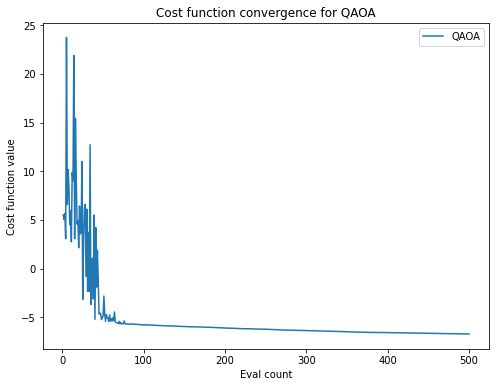

In [11]:
fig, axes = plt.subplots(figsize=(8,6))
plt.plot(np.asarray(qaoa_counts), np.asarray(qaoa_values), label="QAOA")
plt.xlabel('Eval count')
plt.ylabel('Cost function value')
plt.title('Cost function convergence for QAOA')
plt.legend(loc='upper right')
plt.show()